## Step 0: Preparation

In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.2/512.2 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194

In [2]:
import os
os.environ["RAY_DEDUP_LOGS"] = "0"

In [3]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
# from flwr_datasets import FederatedDataset

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.13.1 / PyTorch 2.5.1+cu121


#### Load dataset and preprocessing

In [5]:
# Khi chạy bằng colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# train_1 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/train_FD001.txt"
train_2 = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD002.txt"
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_2 = pd.read_csv(train_2, sep=' ', header=None)
train_2.drop([26, 27], axis=1, inplace=True)
train_2.columns = column_names

train_2['Remaining RUL'] = ''

In [7]:
# remaining_rul = max_rul - cycle
max_cycle = train_2.groupby('ID Engine').count()
for idx in range(len(train_2)):
    train_2.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_2.loc[idx, 'ID Engine'], 'Cycle']
train_2['Remaining RUL'] = train_2['Remaining RUL'] - train_2['Cycle']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# train_1 = train_1.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)
train_2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [9]:
# Normalization
df = train_2.copy()
scaled_columns = df.columns[2:]
scaler = MinMaxScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
df.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.833134,0.997625,1.0,0.060269,0.181576,0.311201,0.273095,0.146592,...,0.992394,0.476508,0.369947,0.0,0.322917,0.651163,1.0,0.156036,0.159082,0.392573
1,1,2,0.999767,0.998575,1.0,0.000000,0.131847,0.296600,0.245535,0.000000,...,0.992229,0.533013,0.381407,0.0,0.281250,0.627907,1.0,0.007888,0.014562,0.389920
2,1,3,0.595096,0.738480,0.0,0.238089,0.016332,0.035297,0.056997,0.293184,...,0.001157,0.039296,0.936731,0.0,0.062500,0.000000,0.0,0.133745,0.151414,0.387268
3,1,4,0.999993,0.999525,1.0,0.000000,0.128269,0.298795,0.246979,0.000000,...,0.992091,0.524349,0.372400,0.0,0.270833,0.627907,1.0,0.014060,0.026144,0.384615
4,1,5,0.595137,0.736698,0.0,0.238089,0.014130,0.037871,0.058152,0.293184,...,0.001075,0.030633,0.937537,0.0,0.062500,0.000000,0.0,0.135460,0.143240,0.381963


In [10]:
def split_dataset(dataset, num_clients):
    """
    Chia dataset thành num_clients tập con đều nhau.
    Args:
        dataset: Dataset cần chia (torch.utils.data.Dataset).
        num_clients: Số lượng tập con muốn tạo.
    Returns:
        List chứa các tập con của dataset.
    """
    # Kích thước mỗi tập con
    subset_size = len(dataset) // num_clients
    sizes = [subset_size] * num_clients

    # Chia phần dư (nếu tổng dataset không chia hết)
    sizes[-1] += len(dataset) - sum(sizes)

    # Tạo danh sách các tập con
    subsets = random_split(dataset, sizes)
    return subsets

In [12]:
class FD002DatasetLoader(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []

        grouped = data.groupby('ID Engine')
        for _, group in grouped:
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values

            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length])
                self.targets.append(rul_values[i + sequence_length - 1])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )


In [13]:
dataset = FD002DatasetLoader(df)
train_data, validation_data = train_test_split(dataset, test_size=0.2, random_state=42)

num_clients = 10
subsets_train = split_dataset(train_data, num_clients)
subsets_validation = split_dataset(validation_data, num_clients)
# Tạo DataLoader cho mỗi tập
client_loader_trains = [DataLoader(subset, batch_size=32, shuffle=True) for subset in subsets_train]
client_loader_validations = [DataLoader(subset, batch_size=32, shuffle=True) for subset in subsets_validation]

# train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [14]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")
    # start_client(train_loader=loader, test_loader=test_loader)

Client 1 will use a subset with 3697 samples
Client 2 will use a subset with 3697 samples
Client 3 will use a subset with 3697 samples
Client 4 will use a subset with 3697 samples
Client 5 will use a subset with 3697 samples
Client 6 will use a subset with 3697 samples
Client 7 will use a subset with 3697 samples
Client 8 will use a subset with 3697 samples
Client 9 will use a subset with 3697 samples
Client 10 will use a subset with 3702 samples


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
for i, loader in enumerate(client_loader_validations):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")
    # start_client(train_loader=loader, test_loader=test_loader)

Client 1 will use a subset with 924 samples
Client 2 will use a subset with 924 samples
Client 3 will use a subset with 924 samples
Client 4 will use a subset with 924 samples
Client 5 will use a subset with 924 samples
Client 6 will use a subset with 924 samples
Client 7 will use a subset with 924 samples
Client 8 will use a subset with 924 samples
Client 9 will use a subset with 924 samples
Client 10 will use a subset with 928 samples


## Step 1: Centralized Training with PyTorch

#### Define the Transformer model

In [16]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])  # Lấy giá trị cuối
        return output.squeeze(-1)

#### Define train function the model

In [17]:
def train(model, client_loader_train, client_loader_validation: None, epochs: int, verbose=False):
    input_dim = 24
    model = model.to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in client_loader_train:
            seq, target = batch
            seq, target = seq.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in client_loader_validation:
                seq, target = batch
                seq, target = seq.to(DEVICE), target.to(DEVICE)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(client_loader_train)}, Val Loss = {val_loss / len(client_loader_validation)}")

In [18]:
def predict_on_batch(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()
    # Lấy một vài mẫu dữ liệu từ tập val_loader
    samples, targets = next(iter(client_loader_validation))  # Lấy một batch từ validation set
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    # Dự đoán với model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        predictions = model(samples)  # [batch_size]
    val_loss = criterion(predictions, targets)

    if return_actual_rul:
        # Đưa kết quả về CPU để xử lý
        samples = samples.cpu()
        targets = targets.cpu()
        predictions = predictions.cpu()

        # Đảo chuẩn hóa dữ liệu
        rul_min = scaler.data_min_[-1]
        rul_max = scaler.data_max_[-1]

        # Đưa predictions và targets về dạng thực tế
        actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
        actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

        if show_fig:
            # Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
            plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
            plt.title("Comparison of Predicted and Actual RUL")
            plt.xlabel("Sample Index")
            plt.ylabel("Remaining Useful Life (RUL)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return val_loss, actual_predictions, actual_targets

    return val_loss


In [19]:
def test(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()

    samples, targets = next(iter(client_loader_validation))
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    # Dự đoán với model
    model.eval()
    val_loss = 0
    accuracys = 0
    with torch.no_grad():
      for batch in client_loader_validation:
        samples, targets = batch
        samples, targets = samples.to(DEVICE), targets.to(DEVICE)
        predictions = model(samples)
        val_loss += criterion(predictions, targets).item()
    return val_loss / len(client_loader_validation)


#### Train the model (Centralized Transformer model)

In [20]:
model = TransformerModel(input_dim=24, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(DEVICE)
train(model=model, client_loader_train=client_loader_trains[0], client_loader_validation=client_loader_validations[0], epochs=5)

Epoch 1: Train Loss = 0.07162535672300849, Val Loss = 0.029179938490791566
Epoch 2: Train Loss = 0.04270317996370381, Val Loss = 0.02854127793348041
Epoch 3: Train Loss = 0.03679424885596181, Val Loss = 0.027505217794457387
Epoch 4: Train Loss = 0.03474266456183175, Val Loss = 0.027112220574555725
Epoch 5: Train Loss = 0.03232335748857465, Val Loss = 0.027129721346086468


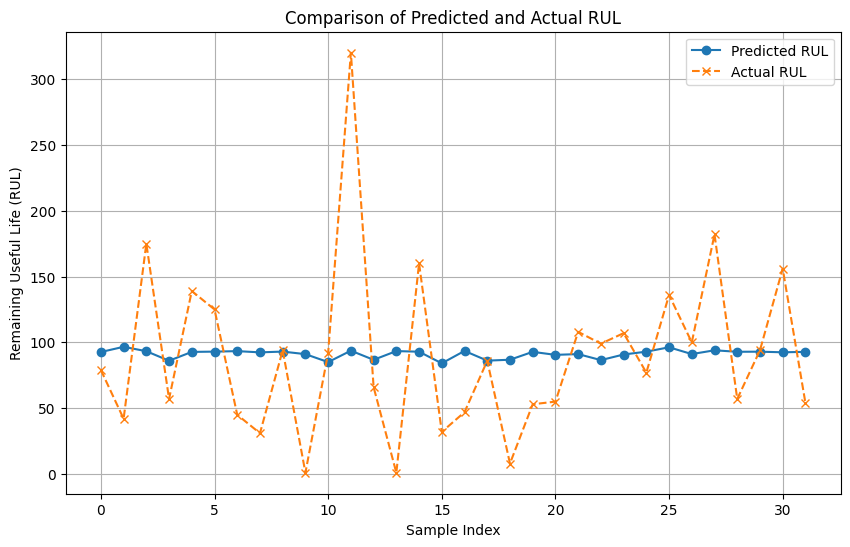

In [21]:
# Dùng tạm validation của client 1 test thử cho model client 0 ở trên!
loss, return_actual_rul, actual_target = predict_on_batch(model=model, client_loader_validation=client_loader_validations[1], return_actual_rul=True, show_fig=True)
print(f'loss={loss}')
print(f'actual rul = {return_actual_rul}')
print(f'actual target={actual_target}')

In [22]:
# Dùng tạm validation của client 1 test thử cho model client 0 ở trên!
loss, return_actual_rul, actual_target = predict_on_batch(model=model, client_loader_validation=client_loader_validations[2], return_actual_rul=True, show_fig=False)
print(f'loss={loss}')
print(f'actual rul = {return_actual_rul}')
print(f'actual target={actual_target}')

loss=0.026760445907711983
actual rul = [85.12525  92.30421  92.44036  92.19244  94.230484 85.90748  92.617905
 94.93275  92.429855 85.311356 94.089714 85.592964 92.342224 90.11816
 92.679695 93.85364  95.43274  85.13211  90.563    92.191315 90.11667
 92.0124   95.81769  95.29205  92.78762  93.09067  93.674286 92.5509
 92.759415 92.87832  92.04593  92.851585]
actual target=[ 17.        65.        13.       173.        85.       128.
  84.        60.       136.        71.       104.        15.
   1.       137.       157.       218.       168.        74.
  95.        52.        65.        29.000002  90.        36.
 133.        33.       125.       118.       220.       188.
  10.       188.      ]


## Step 2: Federated Learning with Flower

#### Update model parameters

In [23]:
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)


def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

#### Define the Flower ClientApp

In [24]:
class FlowerClient(NumPyClient):
    def __init__(self, model, client_loader_train, client_loader_validation):
        self.model = model
        self.trainloader = client_loader_train
        self.valloader = client_loader_validation

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        train(model=self.model, client_loader_train=self.trainloader, client_loader_validation=self.valloader, epochs=1)
        return get_parameters(self.model), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        # loss, accuracy = test(self.model, self.valloader)
        loss = test(
            model=self.model,
            client_loader_validation=self.valloader,
            return_actual_rul=False,
            show_fig=False
        )
        return float(loss), len(self.valloader), {"accuracy": float(0.0)}

In [27]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    model = TransformerModel(input_dim=24, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1).to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader = client_loader_trains[partition_id]
    valloader = client_loader_validations[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

#### Define the Flower ServerApp

In [28]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [29]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=50)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

#### Run the training

In [30]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
# if DEVICE.type == "cuda":
#     backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [ ]:
# Run simulation
NUM_CLIENTS = 10
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=5997) 2024-12-01 14:07:51.472368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=5996) 2024-12-01 14:07:51.481454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=5997) 2024-12-01 14:07:51.548782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=5996) 2024-12-01 14:07:51.567346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to 

(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.05578683897981356, Val Loss = 0.027552750925051755
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.055981491242760216, Val Loss = 0.02727503727736144
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.06013224691409489, Val Loss = 0.0293540321290493
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.05425671089825959, Val Loss = 0.02785056212852741
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.056919273936414515, Val Loss = 0.030066611823336833
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.059089465034676006, Val Loss = 0.028058233510317474
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.05408138150734634, Val Loss = 0.029004847502400136
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.05460585326213261, Val Loss = 0.02744828305881599
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.05189528663096757, Val Loss = 0.02849018503108929


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.05354339229585282, Val Loss = 0.024842953020385628


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.03831311983281169, Val Loss = 0.02673299157799318
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03736538698511391, Val Loss = 0.02461331270249753
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.03972738778925147, Val Loss = 0.026395623026223017
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03938942070215427, Val Loss = 0.026948048444143658
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.03979879686737369, Val Loss = 0.028138231486082077
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.038727097759216, Val Loss = 0.024945996123655088
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03835678863307011, Val Loss = 0.027781971762406415
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.04019394972971801, Val Loss = 0.025745202562418478


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03915852558766973, Val Loss = 0.027894285796531314
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.03906039333227893, Val Loss = 0.02845651521508036


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.034623506816168284, Val Loss = 0.031045724798379273
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.034453212508353696, Val Loss = 0.028358684981177593
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03614492086565186, Val Loss = 0.02763709355274151
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.03516483541321138, Val Loss = 0.02861507532411608
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03524356373939021, Val Loss = 0.02765584788445769
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.03290107359724312, Val Loss = 0.026641891113129156
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03342311265717807, Val Loss = 0.02672685827289162
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.033470973155686055, Val Loss = 0.024794869157003945
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03510154388716508, Val Loss = 0.026504037002551144


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.03416537308808545, Val Loss = 0.024801541440959633


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.03185399049282845, Val Loss = 0.024940672619589443
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03238334782935422, Val Loss = 0.025847728235711312
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.032902823953792966, Val Loss = 0.027395732347564452
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03199383753737242, Val Loss = 0.02634789056048311
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.0319016418853325, Val Loss = 0.02972601415139848
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03355289725907918, Val Loss = 0.027439818749653882
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.030276339501142502, Val Loss = 0.027374321466376042
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03110162109329269, Val Loss = 0.02422937664107002
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.032655672780398666, Val Loss = 0.028282456645934748


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.031947561668167854, Val Loss = 0.027609751399221092


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.029966286672600383, Val Loss = 0.024074361177867855
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03162074370052794, Val Loss = 0.02713549792252738
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.030877968922642798, Val Loss = 0.026289156284825557
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.030777266939523918, Val Loss = 0.02901334893600694
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.032086964006182446, Val Loss = 0.027683409573189145
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.030546034052004588, Val Loss = 0.025070095081524604
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.030762455707159023, Val Loss = 0.027302396965437924
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03307729912921786, Val Loss = 0.025568464257079978
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.029474249751917248, Val Loss = 0.02669213532373823


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03184833429785895, Val Loss = 0.02618168313698522


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02994764227709123, Val Loss = 0.026156427338719368
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02965451271176852, Val Loss = 0.027325294141111702
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.03100953005446956, Val Loss = 0.02529709400801823
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.029969435739170373, Val Loss = 0.03038237398040706
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028550120287350024, Val Loss = 0.026170994251452643
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.030975103370267255, Val Loss = 0.028461706150194693
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02943044069126762, Val Loss = 0.02387315452355763
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.031142839664143735, Val Loss = 0.026101903315505076


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.029785364448767285, Val Loss = 0.027110968427411442
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02958593393900785, Val Loss = 0.02432925029304521


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.029989827287800867, Val Loss = 0.027259358686619793
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02985976813039903, Val Loss = 0.027732230530216777
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028390322378354853, Val Loss = 0.02355416738909894
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.0288629707366485, Val Loss = 0.026988952741797627
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02918649737016651, Val Loss = 0.027567958330799794
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.029519940646172596, Val Loss = 0.02444165116497155
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.030128449426385862, Val Loss = 0.025773933863845366
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.03014471872452775, Val Loss = 0.027279107285470797
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.030657197637804622, Val Loss = 0.026557771778055305


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02794037158761559, Val Loss = 0.026291489793822682


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.029381554565745694, Val Loss = 0.027841934259852458
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02802684770672229, Val Loss = 0.023451528544056004
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028899120576358562, Val Loss = 0.026422978089801197
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.029793739013759226, Val Loss = 0.025516574560054416
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.031179443828697348, Val Loss = 0.02595467541109899
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.028539903903508496, Val Loss = 0.02427855236776944
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.029095702218534105, Val Loss = 0.028582554567476798
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02876936436373869, Val Loss = 0.027285416449966102
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.029485624187208456, Val Loss = 0.027251532493994153


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02778066651381809, Val Loss = 0.027271684837238543


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.028803189646388436, Val Loss = 0.02656389708662855
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028571128772957057, Val Loss = 0.029518144911733168
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.029517903538613485, Val Loss = 0.026482402090111684
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028694299772253323, Val Loss = 0.02819493669888069
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02919476928093053, Val Loss = 0.02693493937238537
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028132651563219983, Val Loss = 0.02400828242815774
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.027201594271022696, Val Loss = 0.026053364645561267
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02830372041829958, Val Loss = 0.023517072778837435
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.030183615162968636, Val Loss = 0.02497442519484923


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028597014578830064, Val Loss = 0.025894959360874933


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.029265004836408228, Val Loss = 0.027244980222192305
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02732330106263017, Val Loss = 0.023071479694596653
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02806588426906744, Val Loss = 0.02672038827862205
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.028664817455513723, Val Loss = 0.02721345867833187
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.026789458669272476, Val Loss = 0.026726817487385767
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.028665631375243437, Val Loss = 0.026883196342608023
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028019058012307203, Val Loss = 0.023884873708774304
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.028845859338240378, Val Loss = 0.026879762524160845
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02948939616406529, Val Loss = 0.02539916410399922


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.030212557553474247, Val Loss = 0.024963605506666774


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028578064741631007, Val Loss = 0.027365270552450215
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.028756790071854305, Val Loss = 0.02629651257704044
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02752081002911617, Val Loss = 0.02532183269745317
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.029331068917787795, Val Loss = 0.02532348467101311
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02883616274479648, Val Loss = 0.02761048322607731
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.027259432509991115, Val Loss = 0.02583217485968409
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02757103981225398, Val Loss = 0.02547783770694815
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02918469378371434, Val Loss = 0.02702080657512977
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02849526086757923, Val Loss = 0.02660211708782048


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026894460801549, Val Loss = 0.023149189603482855


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.027892688931576138, Val Loss = 0.026612234623010815
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.026440712591183597, Val Loss = 0.023438851027910053
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02883520150749848, Val Loss = 0.02443715332654016
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028739618129450185, Val Loss = 0.02664335807464246
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.027915446384777796, Val Loss = 0.025863243780773263
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.028041432852503555, Val Loss = 0.025843932518157465
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028369395808991175, Val Loss = 0.024778980312162434
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026920763904164577, Val Loss = 0.0270754631351808
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.026343583000888085, Val Loss = 0.02529796090876234


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.027775256525211293, Val Loss = 0.024116164844097763


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028877501311744082, Val Loss = 0.0255317196314191
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026091363401441223, Val Loss = 0.024696496540102465
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.029045772096463317, Val Loss = 0.025332707397896666
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026223913983217086, Val Loss = 0.024792201656462818
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.0277981444197739, Val Loss = 0.025884412999810844
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02670139924558843, Val Loss = 0.023400767192501445
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02719964162478673, Val Loss = 0.02683874932599479
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02781366483822208, Val Loss = 0.0288053920556759
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.026359324953679382, Val Loss = 0.022947474350703174


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02776175533453452, Val Loss = 0.025672565150106776


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02740161385033922, Val Loss = 0.025709919535137456
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02754409909087779, Val Loss = 0.02545981183005818
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02594763022076724, Val Loss = 0.023879604574678272
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02778583219082191, Val Loss = 0.024573052719492335
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.027348766336217523, Val Loss = 0.026516442090786737
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026635925823437243, Val Loss = 0.022928525340454333
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.0265360861968506, Val Loss = 0.02478806584559638
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.027067943668827928, Val Loss = 0.027856399722654242
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.028907827848311644, Val Loss = 0.024569160658223874


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.025944204133903158, Val Loss = 0.021751071454892898


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02662559556935368, Val Loss = 0.02473244135235918
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.026827677434053402, Val Loss = 0.027264517924652017
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02539739834851232, Val Loss = 0.025844899616364776
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02605432754478835, Val Loss = 0.024002011223085994
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.027281774175835067, Val Loss = 0.02558743205435317
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026147706450187956, Val Loss = 0.022433708357656824
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02580586474003463, Val Loss = 0.022211193492443396
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026798866392145383, Val Loss = 0.026320944443858903
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.027543120889057374, Val Loss = 0.024012103644681388


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02796814345016048, Val Loss = 0.02315424944691617


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02649419136538074, Val Loss = 0.02419652860483219
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.025061747195712965, Val Loss = 0.021178181251061374
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.027307106206065107, Val Loss = 0.02550424156903193
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02681229873720942, Val Loss = 0.02682152840084043
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02498105158708219, Val Loss = 0.023547785870473962
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.027289979416748572, Val Loss = 0.02295764098907339
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02583106514869322, Val Loss = 0.0235524488420322
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026850939744376932, Val Loss = 0.024224717972864365
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.025906321897717386, Val Loss = 0.02226515583180148


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02704974826714345, Val Loss = 0.025483377020934533


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.026663411633464796, Val Loss = 0.02493320032954216
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.024863563678709084, Val Loss = 0.02058364695002293
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.025268697292254918, Val Loss = 0.022901891891298622
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.025890680294933504, Val Loss = 0.02463849993615315
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.024400643370082152, Val Loss = 0.025398337089552962
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026335174153591025, Val Loss = 0.02455152044522351
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02681232601853794, Val Loss = 0.02236841368521082
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.025355465565647543, Val Loss = 0.023625457370332604
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026410243650577193, Val Loss = 0.023234746579466194


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.025780927694948583, Val Loss = 0.0245491030850801


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02567046764306724, Val Loss = 0.023577823849587606
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.024279962727350408, Val Loss = 0.022372087495851106
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02624152502815785, Val Loss = 0.023361208270592935
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026601014177090133, Val Loss = 0.021781701851507712
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02583008085313285, Val Loss = 0.023831741788007062
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.024933396204342616, Val Loss = 0.02110012122911626
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02445495701876694, Val Loss = 0.02249799566022281
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02550227408586391, Val Loss = 0.023286919880273014
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02439867495559156, Val Loss = 0.022912379482696796


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026000540165616006, Val Loss = 0.024132102310400586


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.024450692412411344, Val Loss = 0.019942691967148204
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02475383726815725, Val Loss = 0.02333919960876991
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.026356307966313487, Val Loss = 0.0211171834119435
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.0254865909910536, Val Loss = 0.024282190049516744
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.023897721215376054, Val Loss = 0.021956893872341204
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.025405285478537452, Val Loss = 0.024518739046721624
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.025539786763617706, Val Loss = 0.022719454855240625
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02440746803767979, Val Loss = 0.021505700263740688
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.025406621918403382, Val Loss = 0.023168943147977877


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02517437067782057, Val Loss = 0.022684799539374894


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.024655535263169943, Val Loss = 0.022561062833872336
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02351053688546707, Val Loss = 0.020383598732537235
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.024069686548720146, Val Loss = 0.02101322912193578
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02411707159099651, Val Loss = 0.023501506524867023
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.025869525744226473, Val Loss = 0.020606928794034595
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02369168027432571, Val Loss = 0.020082068918593998
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.024458651792193795, Val Loss = 0.020710234658728385
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.024713185013689357, Val Loss = 0.02671496358154149
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.024842357214797158, Val Loss = 0.02146059865581578


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.023317229468375444, Val Loss = 0.021398490776532685


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.022591444302414512, Val Loss = 0.01828765975118711
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.024164685425509154, Val Loss = 0.021142409568459822
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.0238464443687478, Val Loss = 0.020013243570153057
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02532292446442719, Val Loss = 0.019060258175535447
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.022358484879328774, Val Loss = 0.020601479850452523
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.023498424120118905, Val Loss = 0.02015042687156077
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02390793505413779, Val Loss = 0.022131765389750743
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02287318481228732, Val Loss = 0.019683185226187623
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02432650867207297, Val Loss = 0.021447275347750764


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.023512017800761707, Val Loss = 0.020847825140788638


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.0234287797136168, Val Loss = 0.01995375113369062
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.022060482232863533, Val Loss = 0.017341881829859882
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.023889662978913765, Val Loss = 0.019725744034452684
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02350282677096026, Val Loss = 0.018335905279321916
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.021777756399764068, Val Loss = 0.019429161406025804
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.022331370707151705, Val Loss = 0.018818463166726047
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.023351979000365425, Val Loss = 0.020945000943952595
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.023193761401263804, Val Loss = 0.019208744810572987
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02211253361872815, Val Loss = 0.021722306208363896


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02210170668068117, Val Loss = 0.018986907402246164


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.022611600146147198, Val Loss = 0.01866481454786042
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02218405810859183, Val Loss = 0.019144587828938305
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.022108120281763118, Val Loss = 0.01665514497214864
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.023030867876388646, Val Loss = 0.017908831994081366
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.021814464190011394, Val Loss = 0.017633969542281382
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.022461770038152563, Val Loss = 0.018271163780370664
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.022562448730178434, Val Loss = 0.01899839793171348
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.023012125471221476, Val Loss = 0.017333155497908592
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.021461100205136783, Val Loss = 0.017515975114857328


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02180003449481366, Val Loss = 0.018685148081517423


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.021486432147051752, Val Loss = 0.017657029570947433
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.020341944150177056, Val Loss = 0.017993841416619975
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.020435063280807488, Val Loss = 0.016741238052731956
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.022079343128756715, Val Loss = 0.01702300388494442
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.020354031777844346, Val Loss = 0.017522646756521588
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02244596658595677, Val Loss = 0.016978822841212667
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.021781836267046887, Val Loss = 0.01779380623765033
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.019836675464015067, Val Loss = 0.016240006762331928
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.021094432309398364, Val Loss = 0.016779882769132483
(ClientAppActor pid=5996) 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.021046167464348776, Val Loss = 0.019922695122659206


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.02058990721205442, Val Loss = 0.01605817171391742
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02089939250385967, Val Loss = 0.016635137867054034
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.020859906586400908, Val Loss = 0.016618135256756997
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.02036212729932419, Val Loss = 0.015692510096163584
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.019565864606631983, Val Loss = 0.015394410343262655
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.020291726458175428, Val Loss = 0.01614701140928885
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.0208662917018579, Val Loss = 0.018028798384656167
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.019440873959583455, Val Loss = 0.016952629939749324
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01944527350334001, Val Loss = 0.014648439073614005


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.021710190135214864, Val Loss = 0.016384759339792974


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.018988399991187555, Val Loss = 0.01560548680095837
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.0189419519798509, Val Loss = 0.01579886373004009
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.020119043352114487, Val Loss = 0.014977554726446497
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.020025458837184925, Val Loss = 0.014560640516594565
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.019165361573084676, Val Loss = 0.015074755354174253
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.019766126217416906, Val Loss = 0.015927101678118623
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.018936407535561715, Val Loss = 0.017721440546728414
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.020127617625583863, Val Loss = 0.017307045644727247
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.018916179153040565, Val Loss = 0.017895326178906292


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.019000440434520614, Val Loss = 0.015097614722968689


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.018166919905242735, Val Loss = 0.015571453704916197
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.018234370766079117, Val Loss = 0.014988049752367982
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.018871410990711945, Val Loss = 0.015460858057285178
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.018136115287077325, Val Loss = 0.014942586454081124
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.018585193741681248, Val Loss = 0.015790493034854018
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01824712911460163, Val Loss = 0.013786741853531065
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.019397787532993947, Val Loss = 0.014673337436698634
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01803325322970491, Val Loss = 0.01481489029488173
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.019543518721736198, Val Loss = 0.013099666267376521


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.018069125683817626, Val Loss = 0.016241987878135567


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.017775059203970534, Val Loss = 0.01243517306986554
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.018151634669830573, Val Loss = 0.015579500492533734
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.018904320289509308, Val Loss = 0.015882881567010593
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.017044901342034853, Val Loss = 0.01736384919234391
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01756955998757019, Val Loss = 0.01522039011891546
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.018195450932172865, Val Loss = 0.015165481893024567
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.017824818637093592, Val Loss = 0.015006738136811503
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.017881608403544743, Val Loss = 0.014887552788673803
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.017977837746127927, Val Loss = 0.014799797377581227


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01887643964286765, Val Loss = 0.014477058570703557


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.018551898795051563, Val Loss = 0.014681651096405655
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01748578738148228, Val Loss = 0.01429894022193962
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.017047757050022483, Val Loss = 0.014176613153440171
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.017732496726615674, Val Loss = 0.014301019961592453
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01787330915123738, Val Loss = 0.012474982951093337
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016885478635607607, Val Loss = 0.013065685229054812
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.016965648071069657, Val Loss = 0.012969623833637813
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01730624641741401, Val Loss = 0.012198634012120551
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.017148087499663234, Val Loss = 0.013155639797834486


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.018179105209379362, Val Loss = 0.014928480128532854


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01722325858708214, Val Loss = 0.01270057199972457
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016470617265440524, Val Loss = 0.01303307808421809
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.017465648923775758, Val Loss = 0.01433058715714463
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016403522310328895, Val Loss = 0.015851958333675205
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.017630938304074365, Val Loss = 0.017909876745322656
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016565268449806447, Val Loss = 0.012229441247623542
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01760079914398877, Val Loss = 0.014340824800832519
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01724799292900696, Val Loss = 0.013826123631462968


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.017333579839785295, Val Loss = 0.01480581502205339
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016438907642591875, Val Loss = 0.014918378923602146


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016612325782951867, Val Loss = 0.013725890761947837
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.0161624369412211, Val Loss = 0.013607637137816897
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01666352548636496, Val Loss = 0.01404520933484209
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01657339720183919, Val Loss = 0.01268976930015046
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01721027151456681, Val Loss = 0.012527141880629391
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016575024226391368, Val Loss = 0.012247684668621113
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.016335209642922312, Val Loss = 0.01228040496915065
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016980569861861396, Val Loss = 0.012862113465009064
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.016722776003759997, Val Loss = 0.013848258856812427


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015376087418628922, Val Loss = 0.012654858737670142


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015800446528812934, Val Loss = 0.012782094919861391
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016871053890068214, Val Loss = 0.012960604038731805
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01641370623035292, Val Loss = 0.013430238733517712
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.016276642439308864, Val Loss = 0.014297559841311184
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01662994392521294, Val Loss = 0.01376802345802044
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015304869237548575, Val Loss = 0.011787526550349491
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01692193152447199, Val Loss = 0.013982426391207966
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015710907699219113, Val Loss = 0.01566008309801591


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015390568605527795, Val Loss = 0.012245289820792347
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015712859606819934, Val Loss = 0.012063973230020753


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015274514933919599, Val Loss = 0.012504713722215644
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015863818947450613, Val Loss = 0.01342465967774905
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01593909488493127, Val Loss = 0.013021813496818831
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01591926679047274, Val Loss = 0.011109775269468283
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01628104799651894, Val Loss = 0.013698670097851548
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015074204998733154, Val Loss = 0.012091769981358585
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01559881228905428, Val Loss = 0.013027767570496633
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.016467585914832508, Val Loss = 0.012389258834822425
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016128012846256125, Val Loss = 0.012735139434065285


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015459035776138049, Val Loss = 0.011634278030873373


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015311836345313952, Val Loss = 0.013243189386638075
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01546791967422027, Val Loss = 0.01142616850998381
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014797561312222788, Val Loss = 0.012586101295490718
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015304125608587316, Val Loss = 0.012283617486085358
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.016015480693975657, Val Loss = 0.013293912955399218
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01557973466797507, Val Loss = 0.012105225970775917
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01588638379350947, Val Loss = 0.012740080116380906
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.016171091143844712, Val Loss = 0.012162918016186049
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01563414415456997, Val Loss = 0.012501064752196443


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015181621532598189, Val Loss = 0.01208249418514556


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015499304197246915, Val Loss = 0.01171252503991127
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01582367780040307, Val Loss = 0.012454984773849619
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015482870468484431, Val Loss = 0.012452698778361082
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015575550119232002, Val Loss = 0.012898470034244758
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015843460480843126, Val Loss = 0.010851454535691902
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014700387644677841, Val Loss = 0.011859119661023905
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015262932219574678, Val Loss = 0.012159990435787317
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014969606978160426, Val Loss = 0.012838770571196902
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015383691257989869, Val Loss = 0.016386695174050742


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01564225664057223, Val Loss = 0.013633841777156139


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015261426062226809, Val Loss = 0.012759203749612487
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015047859854129111, Val Loss = 0.012426081049288142
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014766910647299012, Val Loss = 0.011998535101783687
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014312983382139998, Val Loss = 0.0129560143686831
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.015463301887864182, Val Loss = 0.01176132054614096
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015927384487064235, Val Loss = 0.013274506922682812
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014726439703673381, Val Loss = 0.015362315907560545
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014206542894404766, Val Loss = 0.011973644574654514
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01485437746480878, Val Loss = 0.013801017583444201


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014864722612024895, Val Loss = 0.011363848080408984


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015072434594662025, Val Loss = 0.012228742257916722
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014707508529054707, Val Loss = 0.012487052249368923
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014840450250254622, Val Loss = 0.011906106635157404
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014584232422780117, Val Loss = 0.01169902190630292
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015616379798679003, Val Loss = 0.012433830921634519
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014930309422699541, Val Loss = 0.011596637874327857
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014379676628119216, Val Loss = 0.012383192071113092
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014783081237290954, Val Loss = 0.011571768944248044
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014933543087079608, Val Loss = 0.012304839148218262


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01479248130485287, Val Loss = 0.01210212055593729


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014807055086090133, Val Loss = 0.012002330241275245
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014719658627592284, Val Loss = 0.011740205231411704
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014085778003108913, Val Loss = 0.011546486073398384
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014087755758925501, Val Loss = 0.012554269123437076
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.0147595218310518, Val Loss = 0.012075542343844628
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01492867202112644, Val Loss = 0.012410486373921921
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014499721763623429, Val Loss = 0.012585924745633685
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014867027583210889, Val Loss = 0.0139751472542512
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015642320255524124, Val Loss = 0.011127330555484212


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01533382160765729, Val Loss = 0.011518364306539297


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.01429217371784536, Val Loss = 0.01317142028811163
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.01468041412339642, Val Loss = 0.012096219487359812
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.013457120889958379, Val Loss = 0.01278312828648707
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014720310922712088, Val Loss = 0.013953830211840827
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014403860562416756, Val Loss = 0.012577627368014434
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014532281904770383, Val Loss = 0.012309800785291812
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014978130845802611, Val Loss = 0.011716946365375971
(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.015149544936540568, Val Loss = 0.011686843418484104
(ClientAppActor pid=5996) Epoch 1: Train Loss = 0.014455596896305937, Val Loss = 0.013016550143345677


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5997) Epoch 1: Train Loss = 0.014486860447755918, Val Loss = 0.010734768728886184


#### Where's the accuracy?

In [ ]:
# def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
#     # Multiply accuracy of each client by number of examples used
#     accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
#     examples = [num_examples for num_examples, _ in metrics]

#     # Aggregate and return custom metric (weighted average)
#     return {"accuracy": sum(accuracies) / sum(examples)}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# def server_fn(context: Context) -> ServerAppComponents:
#     """Construct components that set the ServerApp behaviour.

#     You can use settings in `context.run_config` to parameterize the
#     construction of all elements (e.g the strategy or the number of rounds)
#     wrapped in the returned ServerAppComponents object.
#     """

#     # Create FedAvg strategy
#     strategy = FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     )

#     # Configure the server for 5 rounds of training
#     config = ServerConfig(num_rounds=5)

#     return ServerAppComponents(strategy=strategy, config=config)


# # Create a new server instance with the updated FedAvg strategy
# server = ServerApp(server_fn=server_fn)

# # Run simulation
# run_simulation(
#     server_app=server,
#     client_app=client,
#     num_supernodes=NUM_CLIENTS,
#     backend_config=backend_config,
# )